# MAP 435 - TP à trous à rendre pour le dimanche 12 mai 23h59

Le but de cet exercice est de compléter les fonctions manquantes en remplaçant les parties `# YOUR CODE HERE` par votre code.

**Attention** la correction des notebooks se faisant de manière automatique :
- il faut que vous supprimiez la ligne `raise NotImplementedError()` ;
- les seules cellules que vous devez modifier sont celles comportant la mention `# YOUR CODE HERE` ;
- **vous ne devez pas modifier le nom du fichier faute de quoi votre devoir ne sera pas corrigé**.

Merci d'inscrire votre nom dans la cellule ci-dessous.

In [1]:
NOM = "Sabrina Lomelino Sartori"

# Optimisation sous multiples contraintes

Le but de cet exercice est de trouver le minimum d'une fonctionnelle (ni strictement convexe, ni minorée sur $\mathbb{R}^N$) sous deux contraintes inégalités qui assurent l'existence et l'unicité du minimum.

* En premier lieu, en fixant une contrainte active du problème et en éliminant l'autre, on va diminuer le nombre d'inconnues pour mettre en place des algorithmes classiques de descente sans contrainte.
Si la deuxième contrainte n'est pas violée, on a trouvé un minimum.

* Dans un second temps, on mettra en place un algorithme de descente de type Uzawa, avec prise en compte des contraintes, en prenant garde au fait que le problème ne satisfait pas les hypothèses nécessaires à la convergence de cet algorithme.

### Chargement des librairies utilisées

In [2]:
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
from scipy import sparse
from scipy.sparse import linalg, diags

## 1) Mise en place du problème

Soient $C$, $p$ et $q$ trois constantes réelles positives.
On va chercher à minimiser la fonctionnelle quadratique suivante $J: \mathbb R^N \rightarrow \mathbb R$ telle que  
$$ J(x) = \frac12 \langle Ax,x\rangle - C * \langle b,x\rangle,$$
avec :
\begin{equation}
 A=
 \begin{pmatrix}
 1&-1&0&0&0&\ldots &0\\
 -1&2&-1&0& \ddots&\ddots&\vdots\\
 0&-1&2&-1&0&\ddots&\vdots\\
 0&\ddots&\ddots&\ddots&\ddots&\ddots&0\\
 \vdots&\ddots&0&-1&2&-1 &0\\
\vdots&\ddots&\ddots&0&-1&2&-1\\
0&\ldots&0& 0&0& -1&1
\end{pmatrix} \in \mathcal M _{N}(\mathbb R)
\end{equation}
et $b\in \mathbb{R}^N$.
On aurait pu considérer un vecteur $b$ quelconque, mais pour simplifier ce problème, on fixe $b=\mathbb{1}$ le vecteur ne contenant que des $1$.

Comme la matrice $A$ n'est pas définie positive, la fonctionnelle $J$ n'est pas $\alpha$-convexe. On peut remarquer que son noyau contient les constantes. Donc, en posant $\mathbb{1}$ le vecteur ne contenant que des $1$, on obtient pour tout $x\in \mathbb{R}^N$, on a $J(x+2\times\mathbb{1}) = J(x+\mathbb{1}) - C\times N = J(x) - 2\times C\times N$, et $J$ n'est ni strictement convexe, ni minorée.

On impose également les deux contraintes $x_1 \leq p$ et $x_N \leq q$.

On pourrait étudier la convergence théorique des algorithmes de descente en faisant varier la constante $C$, et les deux constantes $p$ et $q$. Mais, pour cet exercice, on va se placer dans un cadre simple où $C=2$ et $p\leq q$. Comme le problème est symétrique en $x_1$ et $x_N$, c'est la constante la plus petite (en l'occurence $p$) qui est susceptible d'être active.

**Q1)** Compléter la fonction `const_A(n)` qui permet de construire la matrice  **creuse** carrée $A$ de taille $n$. **Attention à bien construire une matrice creuse !**

In [3]:
def construire_A(n):
    A = np.zeros((n, n))
    for i in range(1, n-1):
        A[i][i-1] = -1
        A[i][i] = 2
        A[i][i+1] = -1
    A[0][0] = 1
    A[0][1] = -1
    A[n-1][n-2] = -1
    A[n-1][n-1] = 1
    return sparse.csr_matrix(A)

In [4]:
## On vérifie votre matrice A.

# Calcul de la matrice que vous avez construite pour N=10.
mat_A_test=construire_A(10)
# Puis on affiche la matrice sous forme dense pour plus de lisibilité.
print('mat_A = \n',mat_A_test.todense())


mat_A = 
 [[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]]


**Q2)** Compléter la fonction `construire_b` ci-dessous qui permet de construire le vecteur $b$ et la constante $C$.

In [5]:
def construire_b(n):
    b = np.ones(n)
    global C
    C = 2
    return b

In [6]:
## On vérifie votre vecteur b.

# Calcul du vecteur que vous avez construit pour N=10.
vec_b_test=construire_b(10)
# Puis on affiche le vecteur.
print('vec_b = ',vec_b_test)


vec_b =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [7]:
## On construit la matrice A et le vecteur b de notre problème pour N=10.
## Ils seront utilisés dans les questions suivantes.
N = 10
mat_A=construire_A(N)
vec_b=construire_b(N)

**Q3)** Programmer la fonction `fct_J` en utilisant `mat_A` et `vect_b` et la constante $C$.

In [50]:
## Définition de la fonctionnelle J.
def fct_J(x):
    # J = 0.5 * (mat_A @ x) @ x - C * (vec_b @ x)
    J = x @ (0.5*mat_A @ x - C *vec_b) 
    return J

In [18]:
## On teste votre fonctionnelle J sur un vecteur test.
C=2
# Definition d'un vecteur test aléatoire.
x_test=np.random.randn(N)
# Valeur de la fonctionnelle pour ce vecteur test.
print('fct_J(x_test) = ',fct_J(x_test))


fct_J(x_test) =  19.551751294162585


**Q4)** Programmer la fonction `fct_gradJ` qui renvoie le gradient de la fonctionnelle $J$, toujours en utilisant `mat_A`et `vec_b` et la constante $C$.

In [19]:
def fct_gradJ(x):
    grad_J = mat_A @ x - C * vec_b
    return grad_J

In [20]:
## On teste votre gradient de fonctionnelle J sur un vecteur test.

# Definition d'un vecteur test aléatoire.
x_test=np.random.randn(N)
# Valeur du gradient de la fonctionnelle pour ce vecteur test.
print('fct_gradJ(x_test) = ',fct_gradJ(x_test))


fct_gradJ(x_test) =  [-0.56390829 -4.08524617 -0.24295038 -4.60552189  0.56010769 -4.68970071
  0.800278   -3.68137368 -1.15545142 -2.33623315]


**Q5)** Programmer la fonction `contraintes` qui doit rendre 'True' ou 'False', si les contraintes sont respectivement vérifiées ou violées.

In [21]:
def contraintes(x,p,q):
    return (x[0] <= p) and (x[-1] <= q)

In [22]:
## On teste si votre fonction `contraintes` rend le bon résultat.
# On fixe des contraintes.
p = 0
q = 90
# On définit un vecteur test aléatoire.
x_test=np.random.randn(N)
# On affiche le vecteur et le résultat de votre fonction.
print('x_test = ',x_test, ' et contraintes = ',contraintes(x_test,p,q))


x_test =  [ 0.22664037 -2.25104418  2.87089718 -1.48093834 -0.02262924 -0.9893277
 -1.47838913  0.68901715 -0.62091914  1.34026727]  et contraintes =  False


## 2) Algorithmes de descente sans contrainte

Les algorithmes du gradient à pas fixe et à pas optimal vous sont donnés ci-dessous dans les parties 2-a) et 2-b). Ces algorithmes sont complets et **vous n'avez pas à les modifier**. Il n'y a des questions que dans la partie 2-c).
Le but de cette partie est de mettre en place la procédure adéquate pour utiliser ces algorithmes de descente sans contrainte pour traiter le problème précédent.

### 2-a) Algorithme de gradient à pas fixe

On implémente ici la méthode du gradient à pas fixe. 
Les arguments sont : la fonctionnelle à minimiser `f`, son gradient `df` et un point initial`x_init`. On y ajoute les arguments optionnels suivants : le pas du gradient `pas`, la tolérance demandée `tol` et le nombre maximal d'itérations `maxiter`.

On construit la suite $x^{(k)}$ définie par :

\begin{equation}
\left\{
\begin{aligned}
&x^{(0)} \in \mathbb R^N \text{ quelconque} \\
&x^{(k+1)} = x^{(k)} - h \nabla J(x^{(k)}),
\end{aligned}
\right.
\end{equation}

où $h > 0$ est le pas de l'algorithme.


In [23]:
def gradientPasFixe(f,df,x_init,pas=1e-01,tol=1e-06,maxiter=200):
    
    # Initialisation.
    x=x_init.copy()
    xtab=[]
    ftab=[]
    
    xtab.append(x) # On ajoute x à la liste xtab.
    ftab.append(f(x)) # On ajoute f(x) à la liste ftab.
    
    it=0 # Compteur d'itérations.
    
    while((it==0) or (it<maxiter and np.linalg.norm(df(xtab[-1]))>tol)):
        
        # Descente à pas fixe.
        x=x-pas*df(x)
        # Enregistrement des valeurs dans les listes.
        xtab.append(x)
        ftab.append(f(x))
        # Incrementation du compteur.
        it=it+1
    
    # Booléen pour indiquer la convergence.
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv

### 2-b) Algorithme du gradient pas optimal

On implémente maintenant l'algorithme du gradient à pas optimal dans le cas d'une fonctionnelle quadratique (ce qui sera suffisant ici).
On construit donc la suite $x^{(k)}$ définie par :

\begin{equation}
\left\{
\begin{aligned}
&x^{(0)} \in \mathbb R^N \text{ quelconque} \\
&x^{(k+1)} = x^{(k)} - h^{(k)} \nabla J(x^{(k)}),
\end{aligned}
\right.
\end{equation}

où le pas de descente $h^{(k)}$ est choisi tel que :

$$ J(x^{(k+1)})=\min_{h \in \mathbb R} J(x^{(k)}-h\nabla J(x^{(k)})).$$

In [24]:
def gradientPasOpt(f,df,x_init,tol=1e-06,maxiter=200):
    
    # Initialisation.
    x=x_init.copy()
    xtab=[]
    ftab=[]
    
    xtab.append(x) # On ajoute x à la liste xtab.
    ftab.append(f(x)) # On ajoute f(x) à la liste ftab.
    
    it=0 # Compteur d'itérations.
    
    while((it==0) or (it<maxiter and np.linalg.norm(df(xtab[-1]))>tol)):
        
        # Calcul du pas optimal.
        r=df(x)
        b=df(0*x)
        matAr=df(r)-b
        pas=np.dot(r,r)/np.dot(r,matAr)
        # Descente à pas optimal.
        x=x-pas*df(x)
        # Enregistrement des valeurs dans les listes.
        xtab.append(x)
        ftab.append(f(x))
        # Incrementation du compteur.
        it=it+1
    
    # Booléen pour indiquer la convergence.
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv

### 2-c) Nouvelle fonctionnelle sans contrainte à gauche
Si on fixe la valeur de $x_1$ à la valeur $p$ de la contrainte à gauche, alors le problème devient sans contrainte à gauche, mais il faut modifier la fonctionnelle en conséquence.

**Q6)** Modifier la fonctionnelle $J$ pour construire une fonctionnelle $J_g: \mathbb R^{N-1} \rightarrow \mathbb R$ qui s'applique à un vecteur $x:=(x_2, \dots, x_N)$ telle que $J_g(x) = J(y)$ avec $y=(p,x)$ le vecteur de $R^N$ avec  sa valeur extrémale gauche $y_1$ fixée à la valeur $p$, i.e.
$$
J_g(x) = p\left(A_{1,1}p + \sum_{j=2}^N A_{1,j}x_j\right) + \sum_{i=2}^N  x_i\left(A_{i,1}p + \sum_{j=2}^N A_{i,j}x_j\right) - \sum_{i=2}^N b_i x_i - b_1 p.
$$
Programmer la fonction `fct_J_gauche` qui s'applique sur un vecteur $x$ de $\mathbb R^{N-1}$ et qui le complète avec la valeur $p$ de la contrainte dans sa composante $x_1$.
Attention, la valeur de $p$ est une valeur globalement définie qui doit apparaître dans l'écriture de la fonction `fct_J_gauche` pour construire le vecteur $y=(p,x)$.

In [55]:
## Définition de la fonctionnelle J_g.
def fct_J_gauche(x):
    global p
    N = len(x)
    A = construire_A(N+1)
    b = construire_b(N+1)
    y = np.insert(x, 0, p)
    Jg = y @ (0.5*A @ y - C*b)
    return Jg

In [56]:
## Verifier votre fonctionnelle J_g
p = 0
print('fct_J_gauche(x_test) = ',fct_J_gauche([10,20,30,40,50,60,70,80,90]))
print('fct_J(x_test) = ',fct_J([0,10,20,30,40,50,60,70,80,90]))


fct_J_gauche(x_test) =  -450.0
fct_J(x_test) =  -450.0


**Q7)** Programmer la fonction `fct_gradJ_gauche`qui renvoie le gradient de la fonction $J_g$.

In [68]:
def fct_gradJ_gauche(x):
    global p
    y = np.insert(x, 0, p)
    N = len(x)
    A = construire_A(N+1)
    b = construire_b(N+1)
    # grad_Jg = 2 * A @ y - b
    grad_Jg = A @ y - C* b
    return grad_Jg[1:]

In [69]:
## Verifier votre valeur du gradient de la fonctionnelle J_g.
p = 0
print('fct_gradJ_gauche(x_test) = ',fct_gradJ_gauche([10,20,30,40,50,60,70,80,90]))


fct_gradJ_gauche(x_test) =  [-2. -2. -2. -2. -2. -2. -2. -2.  8.]


On peut maintenant appliquer les algorithmes de gradient à pas fixe et pas optimal à cette nouvelle fonctionnelle $J_g$. Concernant l'algorithme de gradient à pas fixe, on peut fixer ce pas à une valeur "optimale" si on connaît les valeurs propres de la matrice $A$.

Pour tester la convergence, on a besoin d'une solution exacte. Dans le cas particulier où $N=10$, $C=2$, $p=0$ et $q=90$, on peut montrer que la solution du problème est le vecteur
$(0, 18, 34, 48, 60, 70, 78, 84, 88, 90)$.

In [70]:
# On fixe les paramètres N=10, C=2, p=0 et q=90 pour tester les méthodes.
N = 10
C = 2
p = 0
q = 90

# Calcul des valeurs propres "vp" de la matrice A pour pouvoir calculer le pas optimal.
vp,_=np.linalg.eigh(mat_A.todense())

# Plus grande valeur propre de A.
vp_max=np.max(vp)

# Plus petite valeur propre de A.
vp_min=np.min(vp)

# Pas optimal pour l'algorithme du gradient à pas fixe.
pas_fixe = 4/(3*(vp_min+vp_max))

# Pour ce choix précis de paramètres, la solution exacte est
sol_complete = np.array([0, 18, 34, 48, 60, 70, 78, 84, 88, 90])
# On enlève sa première composante pour obtenir un vecteur de taille N-1.
sol = np.array([18, 34, 48, 60, 70, 78, 84, 88, 90])

# On choisit un point de départ aléatoire pour tester la convergence des algorithmes.
x_init=np.random.randn(N-1)

In [71]:
print('vp_min=',vp_min,' vp_max=',vp_max,' pas_fixe=',pas_fixe)

vp_min= -5.164518117804871e-16  vp_max= 3.902113032590307  pas_fixe= 0.3416952103123056


In [74]:
print('=================================')
print('Algorithme du gradient à pas fixe')
x_PasFixe, f_PasFixe, conv_PasFixe = gradientPasFixe(fct_J_gauche,fct_gradJ_gauche,x_init,pas_fixe,1e-6,5000)
print('Erreur = ',np.linalg.norm(sol-x_PasFixe[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe)[0]-1)
print('Solution approchée = ',x_PasFixe[-1])

print('=================================')
print('Algorithme du gradient à pas optimal')
x_PasOpt, f_PasOpt, conv_PasOpt = gradientPasOpt(fct_J_gauche,fct_gradJ_gauche,x_init,1e-6,5000)
print('Erreur = ',np.linalg.norm(sol-x_PasOpt[-1]))
print('Convergence =',conv_PasOpt)
print('Nombre d itérations = ',np.shape(x_PasOpt)[0]-1)
print('Solution approchée = ',x_PasOpt[-1])

Algorithme du gradient à pas fixe
Erreur =  3.63776520362637e-05
Convergence = True
Nombre d itérations =  1660
Solution approchée =  [17.99999725 33.99999458 47.99999206 59.99998975 69.99998772 77.99998603
 83.99998471 87.99998382 89.99998337]
Algorithme du gradient à pas optimal
Erreur =  2.663077726426402e-05
Convergence = True
Nombre d itérations =  1123
Solution approchée =  [17.99999801 33.99999598 47.99999425 59.99999242 69.99999109 77.9999897
 83.99998887 87.99998812 89.99998784]


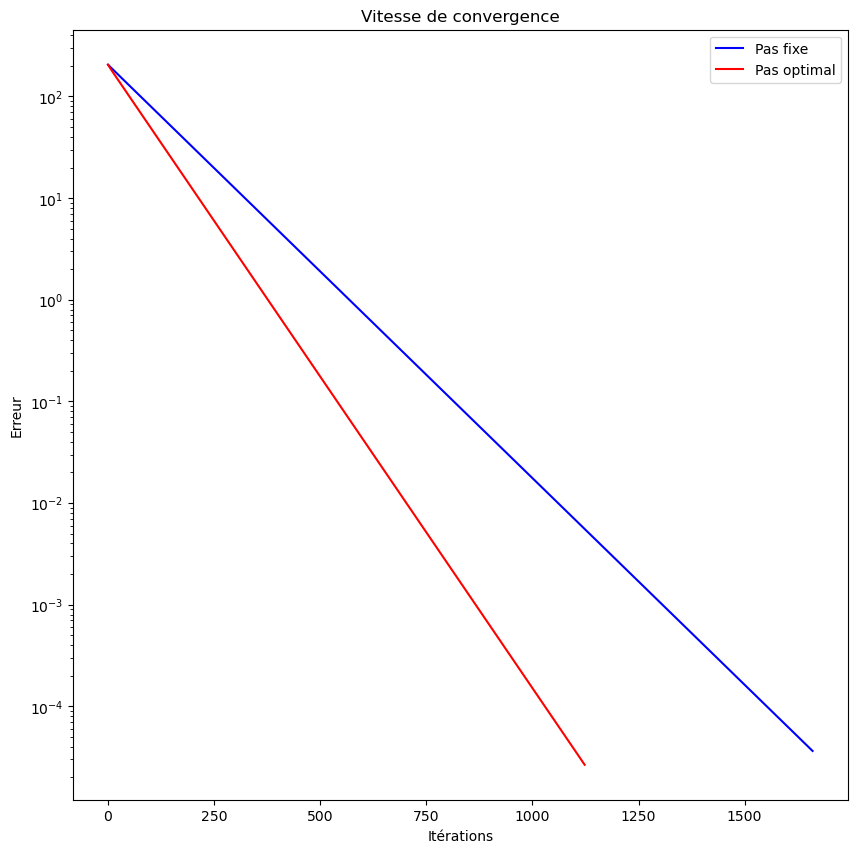

In [75]:
# On affiche la convergence des algorithmes.
plt.figure(figsize=(10, 10))
plt.semilogy(np.linalg.norm(x_PasFixe-sol,axis=1),'-b')
plt.semilogy(np.linalg.norm(x_PasOpt-sol,axis=1),'-r')
plt.legend(['Pas fixe','Pas optimal'])
plt.title('Vitesse de convergence')
plt.xlabel('Itérations')
plt.ylabel('Erreur')
plt.show()

## 3) Algorithmes de descente avec contraintes

Dans cette section, on va mettre en place la procédure adéquate pour utiliser un algorithme de descente avec contraintes. Il s'agit de l'algorithme d'Uzawa.

Pour cela, on définit le lagrangien
$$
\mathcal L (x,\mu) = J(x) + \mu_g (x_1-p)+ \mu_d (x_N-q)
$$
et on remarque que lorsque les deux multiplicateurs de Lagrange $\mu_g$ et $\mu_d$ sont fixés, alors le lagrangien $\mathcal L$ est simplement une fonctionnelle quadratique de la forme $J_L : \mathbb R^{N} \rightarrow \mathbb R$ qui s'applique à un vecteur $x:=(x_1, \dots, x_N)$ telle que
$$
J_L(x) = \sum_{i=1}^N x_i \left(\sum_{j=1}^N A_{i,j}x_j\right) - \sum_{i=1}^{N-1} \tilde{b}_i x_i + G(\mu_g,p,\mu_d,q)
$$
avec $\tilde{b}_1 = b_1 - \mu_g$, $\tilde{b}_N = b_N - \mu_d$, $\tilde{b}_i = b_i$ pour $2 \leq i \leq N-1$ et $G(\mu_g,p,\mu_d,q)=-\mu_g p - \mu_d q$.




**Q8)** Programmer la fonction `fct_J_L`.

In [97]:
## Définition de la fonctionnelle J_L.
# On fixe les multiplicateurs de Lagrange et les contraintes à des valeurs arbitraires.
# Ces valeurs seront modifiées plus tard.
p = 0
mu_g = 5
q = 90
mu_d = 7
def fct_J_L(x):
    G = - mu_g*p - mu_d*q
    b = vec_b
    b[0] = b[0] - mu_g
    b[-1] = b[-1] - mu_d
    Jl = x @ (mat_A @ x - b) + G #+ b[-1]*x[-1]
    return Jl

In [98]:
## Verifier vos valeurs.
x_test = np.append(p,[10,30,20,50,40,70,60,80,q])
# Si les contraintes sont actives les fonctionnelles doivent coincider.
print('fct_J(x_test)=',fct_J(x_test))
print('fct_J_L(x_test)=',fct_J_L(x_test))


fct_J(x_test)= 10730.0
fct_J_L(x_test)= 7690.0


**Q9)** Programmer la fonction `fct_gradJ_L` qui renvoie le gradient de la fonction $J_L$.

In [ ]:
## Définition du gradient de la fonctionnelle J_L.
def fct_gradJ_L(x):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
## Verifier vos valeurs.
x_test = np.append(p,[10,30,20,50,40,70,60,80,q])
# Si les contraintes sont actives les gradients devraient
# différer dans les directions des contraintes
# (en fonction des valeurs données aux multiplicateurs de Lagrange).
print('fct_gradJ(x_test)=',fct_gradJ(x_test))
print('fct_gradJ_L(x_test)=',fct_gradJ_L(x_test))


On rappelle l'algorithme d'Uzawa sur le Lagrangien $\mathcal{L}$. La première des deux étapes d'Uzawa est une étape d'optimisation, et on pourra appliquer un gradient à pas fixe ou à pas optimal pour résoudre cette étape. La deuxième étape est l'étape de mise-à-jour à pas fixe du multiplicateur de Lagrange, suivie d'une projection. On répète ces deux étapes pour $k\in \mathbb{N}$ jusqu'à convergence:
\begin{equation}
\left\{
\begin{aligned}
&\lambda^{(0)}\in \mathbb{R}_+^2 \text{ quelconque} \\
&x^{(k)} = \mathrm{arginf}_{x \in \mathbb{R}^N} \mathcal{L}(x,\lambda^{(k)})\\
&\lambda^{(k+1)} = \Pi_{\mathbb{R}_+^2}(\lambda^{(k)} + h (x^{(k)}_1-p,x^{(k)}_N-q))
\end{aligned}
\right.
\end{equation}
où le pas $h$ de la deuxième étape est fixé.

Afin de décomposer l'algorithme d'Uzawa en plusieurs étapes, on va programmer les différentes étapes dans différentes fonctions.

Remarque importante: Pour pouvoir comparer aux algorithmes précédents, on commencera par un vecteur $x_{init} \in \mathbb{R}^{N-1}$ choisi aléatoirement complété par la contrainte $x_1=p$ dans sa première composante pour obtenir un vecteur $x^{(-1)} \in \mathbb{R}^{N}$. On fixera également $\lambda^{(-1)}=(0,0)$, et on fera l'étape deux pour trouver la valeur de $\lambda^{(0)}$ initiale qui permet de démarrer l'algorithme d'Uzawa.

Autre remarque importante: Attention ! La fonctionnelle $J$ n'est ni $\alpha$-convexe, ni strictement convexe, ni même minorée dans $\mathbb{R}^N$ donc, dans l'étape 1, il n'y a aucune raison que les algorithmes à pas fixe ou pas optimal convergent. Il n'y a pas de solution pour y remédier. En pratique, si $\lambda^{(-1)}$ et $x^{(-1)}$ sont choisis proches des solutions, et si l'algorithme à pas fixe ne fait pas trop d'itérations, l'algorithme d'Uzawa va converger.

**Q10)** Compléter la fonction `etape_deux` qui effectue la mise-à-jour des deux multiplicateurs de Lagrange selon l'étape 2 de l'algorithme d'Uzawa pour des valeurs données en argument (`multi_in`, `pas_uzawa`, `vecteur_x`) avec `multi_in` = $\lambda^{(k)}$ contenant les deux multiplicateurs dans `multi_in[0]` et `muti_in[1]`, `pas_uzawa`= $h$ et `vecteur_x` le vecteur $(x^{(k)}_1, \dots, x^{(k)}_N)$. La sortie prend la forme de la donnée `multi_out` préconisée ci-dessous.

In [ ]:
## Définition de la mise-à-jour des deux multiplicateurs de Lagrange dans J_L.
def etape_deux(multi_in, pas_uzawa, vecteur_x):
    multi_out=[0,0]
    # YOUR CODE HERE
    raise NotImplementedError()
    return multi_out

In [ ]:
## Verifier votre mise à jour à l'étape 2.
## avec les conditions suivantes :
x_test = np.append(p,[10,30,20,50,40,70,60,80,q])
print('Nouveau multiplicateurs = ',etape_deux([1,2], 0.01, x_test))
x_test = np.append(p-1,[10,30,20,50,40,70,60,80,q])
print('Nouveau multiplicateurs = ',etape_deux([1,2], 0.01, x_test))


On définit l'algorithme d'Uzawa suivant. "Normalement", tout devrait bien se passer, et les cellules suivantes illustrent la vitesse de convergence de cet algorithme.

In [ ]:
def uzawa(f,df,x_init,pas_uzawa,tol=1e-06,maxiter=1000):
    
    global mu_g # Pour pouvoir modifier les valeurs de mu_g dans J_L.
    global mu_d # Pour pouvoir modifier les valeurs de mu_d dans J_L.
    
    # Initialisation.
    # x_init est un vecteur de R^{N-1}
    # Le vecteur y est un vecteur de R^N, sa première composante est initialisée
    # à la contrainte p et le multiplicateur \lambda est initialisé à (0,0)
    x=x_init.copy()
    y=np.append(p,x)
    l=[0,0]
    xtab=[]
    ltab=[]
    ftab=[]
    
    xtab.append(x) # On ajoute x à la liste xtab.
    ltab.append(l) # On ajoute l à la liste ltab.
    ftab.append(f(y)) # On ajoute f(y) à la la liste ftab.
    # Attention, la fonction f agit bien sur un vecteur de R^N, donc sur y.
    
    it=0 # Compteur d'itérations.
    
    while((it==0) or (it<maxiter and np.linalg.norm(df(y))>tol)):
        # print('Uzawa: iteration numero ',it)
        # Mise-à-jour des multiplicateurs de Lagrange dans J_L.
        mu_g = l[0]
        mu_d = l[1]

        # Recherche du minimum du Lagrangien avec les multiplicateurs de Lagrange fixés
        # par un algorithme de gradient à pas fixe.
        # On force un faible nombre d'itérations dans l'algorithme à pas fixe
        # pour éviter des divergences à cette étape.
        y_PasFixe, f_PasFixe, conv_PasFixe = gradientPasFixe(f,df,y,pas_fixe,tol,10)
        y = y_PasFixe[-1]
        # Increment à pas fixe des multiplicateurs de Lagrange.
        l = etape_deux(l, pas_uzawa, y)
        
        # Enregistrement des valeurs dans les tableaux.
        x=y[1:]
        xtab.append(x)
        ltab.append(l)
        ftab.append(f(y))
        
        # Incrementation du compteur de boucle.
        it=it+1
    
    # Booléen pour indiquer la convergence.
    if(it==maxiter) or (np.isnan(np.linalg.norm(y))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv

In [ ]:
# La taille du pas_fixe pour l'algorithme de gradient à pas fixe a été calculée préalablement.
# Taille du pas dans l'algorithme d'Uzawa.
pas_uzawa = 0.1
print('pas_fixe =',pas_fixe,' pas_uzawa =',pas_uzawa)

# Verification de la convergence de l'algorithme d'Uzawa.
N = 10
C = 2
p = 0
q = 90
mu_g = 20
mu_d = 0
pas_uzawa = 0.1
sol_Uzawa_true = np.array([18, 34, 48, 60, 70, 78, 84, 88, 90])

print('N, C, p, q, mu_g, mu_d =',N, C, p, q, mu_g, mu_d)

# Initialisation d'un vecteur dans R^{N-1}.
# On peut tester avec un point random.
x_init_test = np.array([-0.48004334, -1.02918846, 0.22171496, 0.72766597, -0.31981484,
                   -0.93797772, 0.39566158, 1.18174939, -1.03269128])
x_Uzawa_student, f_Uzawa_student, conv_Uzawa_student = uzawa(fct_J_L,fct_gradJ_L,x_init_test,pas_uzawa,1e-6,1000)
sol_Uzawa_student = x_Uzawa_student[-1]

# On peut tester avec la vraie solution comme point initial.
x_init_test = sol_Uzawa_true
x_Uzawa_student, f_Uzawa_student, conv_Uzawa_student = uzawa(fct_J_L,fct_gradJ_L,x_init_test,pas_uzawa,1e-6,1000)
sol_Uzawa_student = x_Uzawa_student[-1]

In [ ]:
print('=================================')
print('Algorithme d''Uzawa')
x_Uzawa, f_Uzawa, conv_Uzawa = uzawa(fct_J_L,fct_gradJ_L,x_init,pas_uzawa,1e-6,1000)
print('Erreur = ',np.linalg.norm(sol-x_Uzawa[-1]))
print('Convergence =',conv_Uzawa)
print('Nombre d itérations = ',np.shape(x_Uzawa)[0]-1)
print('Solution approchée = ',x_Uzawa[-1])

In [ ]:
# On affiche la convergence des algorithmes.
plt.figure(figsize=(10, 10))
plt.semilogy(np.linalg.norm(x_PasFixe-sol,axis=1),'-b')
plt.semilogy(np.linalg.norm(x_PasOpt-sol,axis=1),'-r')
plt.semilogy(np.linalg.norm(x_Uzawa-sol,axis=1),'-g')
plt.legend(['Pas fixe','Pas optimal','Uzawa'])
plt.title('Vitesse de convergence')
plt.xlabel('Itérations')
plt.ylabel('Erreur')
plt.show()